# Insurance cost prediction using linear regression

In this notebook we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from [Kaggle](https://www.kaggle.com/mirichoi0218/insurance).


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model

In [1]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

<IPython.core.display.Javascript object>

In [2]:
project_name='02-insurance-linear-regression'

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [3]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: ./insurance.csv


To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [4]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [5]:
your_name = "Priyanshu"

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [6]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [7]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,charges
240,23,female,41.8038,2,yes,40437.209715
651,53,female,45.1440,1,no,11108.696550
761,23,male,40.1280,1,no,2537.802750
836,36,male,35.9100,0,no,4622.344650
1147,20,female,36.3888,0,no,2374.647240


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [8]:
num_rows = len(dataframe)
print(num_rows)

1271


**Q: How many columns doe the dataset have?**

In [9]:
num_cols = len(dataframe.columns)
print(num_cols)

6


**Q: What are the column titles of the input variables?**

In [10]:
input_cols = ["age", "sex", "bmi", "children", "smoker"]
input_cols

['age', 'sex', 'bmi', 'children', 'smoker']

**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [11]:
categorical_cols = dataframe.select_dtypes('object').columns.to_list()
categorical_cols

['sex', 'smoker']

**Q: What are the column titles of output/target variable(s)?**

In [12]:
output_cols = [dataframe.columns[5]]
output_cols

['charges']

**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

In [13]:
min_val = dataframe["charges"].min()
print("The minimun value of the charges column is: {:.2f}".format(min_val))

max_val = dataframe["charges"].max()
print("The minimun value of the charges column is: {:.2f}".format(max_val))

avg_val = dataframe["charges"].mean()
print("The minimun value of the charges column is: {:.2f}".format(avg_val))

The minimun value of the charges column is: 1177.97
The minimun value of the charges column is: 66958.95
The minimun value of the charges column is: 14042.10


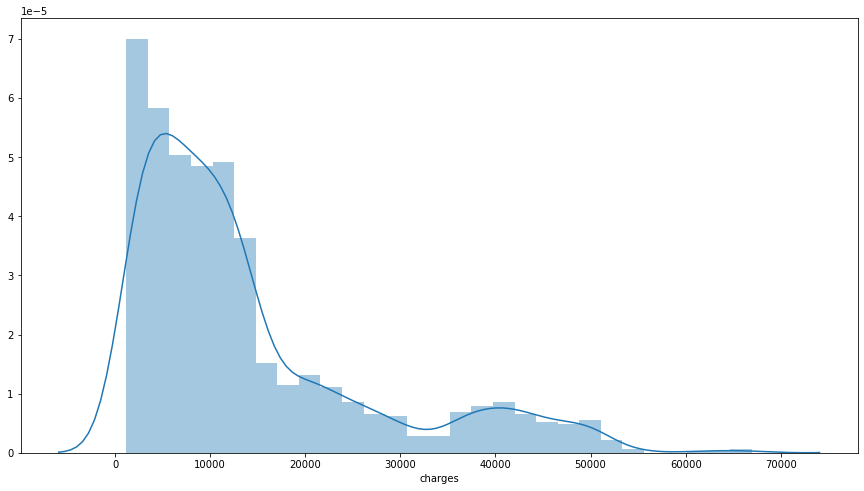

In [14]:
import seaborn as sns

plt.figure(figsize=(15,8))
sns.distplot(dataframe.charges, kde=True);

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [15]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [16]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[23.    ,  0.    , 41.8038,  2.    ,  1.    ],
        [53.    ,  0.    , 45.144 ,  1.    ,  0.    ],
        [23.    ,  1.    , 40.128 ,  1.    ,  0.    ],
        ...,
        [59.    ,  0.    , 41.9121,  1.    ,  1.    ],
        [53.    ,  0.    , 37.905 ,  0.    ,  0.    ],
        [48.    ,  0.    , 37.9962,  0.    ,  0.    ]]),
 array([[40437.209715 ],
        [11108.69655  ],
        [ 2537.80275  ],
        ...,
        [50291.6309175],
        [11093.128725 ],
        [ 8697.864735 ]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [17]:
inputs = torch.tensor(inputs_array, dtype=torch.float32)
targets = torch.tensor(targets_array, dtype=torch.float32)

In [18]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [19]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets.**

In [20]:
val_percent = 0.150 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds =  random_split(dataset, [train_size, val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [38]:
batch_size = 40

In [39]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [40]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[39.0000,  1.0000, 24.9090,  1.0000,  0.0000],
        [23.0000,  0.0000, 38.0760,  0.0000,  0.0000],
        [53.0000,  0.0000, 42.6702,  1.0000,  0.0000],
        [43.0000,  1.0000, 34.3311,  3.0000,  0.0000],
        [55.0000,  0.0000, 42.2940,  0.0000,  0.0000],
        [55.0000,  1.0000, 42.5220,  0.0000,  0.0000],
        [64.0000,  0.0000, 26.2086,  0.0000,  1.0000],
        [56.0000,  1.0000, 45.9420,  0.0000,  0.0000],
        [35.0000,  0.0000, 39.6720,  1.0000,  0.0000],
        [38.0000,  1.0000, 39.5580,  2.0000,  0.0000],
        [28.0000,  0.0000, 27.7248,  1.0000,  0.0000],
        [40.0000,  0.0000, 37.6200,  3.0000,  0.0000],
        [26.0000,  0.0000, 34.1088,  2.0000,  0.0000],
        [50.0000,  0.0000, 31.7262,  3.0000,  0.0000],
        [64.0000,  0.0000, 41.0058,  0.0000,  0.0000],
        [60.0000,  1.0000, 37.7454,  3.0000,  0.0000],
        [48.0000,  1.0000, 31.9200,  1.0000,  1.0000],
        [25.0000,  0.0000, 38.7486,  1.0000,  0.0000],
  

Let's save our work by committing to Jovian.

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [47]:
input_size = len(input_cols)
output_size = len(output_cols)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [48]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                 # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = nn.functional.l1_loss(out,targets)                         # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = nn.functional.l1_loss(out,targets)                           # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [49]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [50]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.1921,  0.1329, -0.1697, -0.4464, -0.1952]], requires_grad=True),
 Parameter containing:
 tensor([-0.2021], requires_grad=True)]

One final commit before we train the model.

In [51]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "priyanshu-kr/02-insurance-linear-regression" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ai/priyanshu-kr/02-insurance-linear-regression


'https://jovian.ai/priyanshu-kr/02-insurance-linear-regression'

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [52]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [53]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 14939.951171875}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [54]:
epochs = 500
lr = 1e-2
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8595.2998
Epoch [40], val_loss: 8462.2793
Epoch [60], val_loss: 8393.5723
Epoch [80], val_loss: 8328.6523
Epoch [100], val_loss: 8268.8604
Epoch [120], val_loss: 8214.1357
Epoch [140], val_loss: 8162.1416
Epoch [160], val_loss: 8123.2471
Epoch [180], val_loss: 8080.6611
Epoch [200], val_loss: 8064.6221
Epoch [220], val_loss: 8044.7930
Epoch [240], val_loss: 8032.7041
Epoch [260], val_loss: 8031.7251
Epoch [280], val_loss: 8027.2178
Epoch [300], val_loss: 8029.8271
Epoch [320], val_loss: 8028.0454
Epoch [340], val_loss: 8029.6328
Epoch [360], val_loss: 8023.3062
Epoch [380], val_loss: 8025.4155
Epoch [400], val_loss: 8022.5752
Epoch [420], val_loss: 8023.4678
Epoch [440], val_loss: 8016.3877
Epoch [460], val_loss: 8020.0063
Epoch [480], val_loss: 8023.8804
Epoch [500], val_loss: 8019.0791


In [55]:
epochs = 500
lr = 1e-3
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8018.4194
Epoch [40], val_loss: 8019.1104
Epoch [60], val_loss: 8018.0928
Epoch [80], val_loss: 8018.5454
Epoch [100], val_loss: 8018.4404
Epoch [120], val_loss: 8017.7021
Epoch [140], val_loss: 8017.5039
Epoch [160], val_loss: 8018.1123
Epoch [180], val_loss: 8019.4697
Epoch [200], val_loss: 8018.3540
Epoch [220], val_loss: 8017.9541
Epoch [240], val_loss: 8017.5469
Epoch [260], val_loss: 8017.3057
Epoch [280], val_loss: 8017.6240
Epoch [300], val_loss: 8016.9971
Epoch [320], val_loss: 8017.2798
Epoch [340], val_loss: 8016.8345
Epoch [360], val_loss: 8018.2275
Epoch [380], val_loss: 8018.2749
Epoch [400], val_loss: 8018.2236
Epoch [420], val_loss: 8017.6929
Epoch [440], val_loss: 8016.7124
Epoch [460], val_loss: 8017.4141
Epoch [480], val_loss: 8018.1924
Epoch [500], val_loss: 8017.1797


In [56]:
epochs = 500
lr = 1e-4
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8017.1978
Epoch [40], val_loss: 8017.1938
Epoch [60], val_loss: 8017.1748
Epoch [80], val_loss: 8017.1812
Epoch [100], val_loss: 8016.9639
Epoch [120], val_loss: 8016.9868
Epoch [140], val_loss: 8016.9751
Epoch [160], val_loss: 8017.0610
Epoch [180], val_loss: 8017.0264
Epoch [200], val_loss: 8016.9658
Epoch [220], val_loss: 8016.9780
Epoch [240], val_loss: 8017.0767
Epoch [260], val_loss: 8017.1382
Epoch [280], val_loss: 8017.0757
Epoch [300], val_loss: 8017.1396
Epoch [320], val_loss: 8017.2485
Epoch [340], val_loss: 8017.2432
Epoch [360], val_loss: 8017.2627
Epoch [380], val_loss: 8017.3062
Epoch [400], val_loss: 8017.3579
Epoch [420], val_loss: 8017.2671
Epoch [440], val_loss: 8017.1860
Epoch [460], val_loss: 8017.2197
Epoch [480], val_loss: 8017.2710
Epoch [500], val_loss: 8017.3604


In [57]:
epochs = 500
lr = 1e-2
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8011.1943
Epoch [40], val_loss: 8015.3447
Epoch [60], val_loss: 8015.4365
Epoch [80], val_loss: 8019.4985
Epoch [100], val_loss: 8011.8252
Epoch [120], val_loss: 8019.7148
Epoch [140], val_loss: 8011.6709
Epoch [160], val_loss: 8014.7695
Epoch [180], val_loss: 8016.7485
Epoch [200], val_loss: 8009.6709
Epoch [220], val_loss: 8010.2524
Epoch [240], val_loss: 8010.0366
Epoch [260], val_loss: 8009.0479
Epoch [280], val_loss: 8014.5518
Epoch [300], val_loss: 8007.4922
Epoch [320], val_loss: 8006.6704
Epoch [340], val_loss: 8002.3608
Epoch [360], val_loss: 8006.2017
Epoch [380], val_loss: 8001.3857
Epoch [400], val_loss: 8005.4297
Epoch [420], val_loss: 8003.9272
Epoch [440], val_loss: 8002.4697
Epoch [460], val_loss: 8004.8179
Epoch [480], val_loss: 8000.0654
Epoch [500], val_loss: 7997.1538


In [60]:
epochs = 500
lr = 0.3
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6504.6523
Epoch [40], val_loss: 6377.2412
Epoch [60], val_loss: 6481.1270
Epoch [80], val_loss: 6479.4922
Epoch [100], val_loss: 6700.7686
Epoch [120], val_loss: 6385.6357
Epoch [140], val_loss: 6498.8262
Epoch [160], val_loss: 6379.2490
Epoch [180], val_loss: 6411.5601
Epoch [200], val_loss: 6387.2212
Epoch [220], val_loss: 6499.8760
Epoch [240], val_loss: 6395.2734
Epoch [260], val_loss: 6523.8389
Epoch [280], val_loss: 6488.2031
Epoch [300], val_loss: 6452.4048
Epoch [320], val_loss: 6426.4189
Epoch [340], val_loss: 6400.9531
Epoch [360], val_loss: 6391.1616
Epoch [380], val_loss: 6314.5249
Epoch [400], val_loss: 6374.1978
Epoch [420], val_loss: 6217.5376
Epoch [440], val_loss: 6406.2651
Epoch [460], val_loss: 6569.1289
Epoch [480], val_loss: 6291.9253
Epoch [500], val_loss: 6426.6729


**Q: What is the final validation loss of your model?**

In [61]:
val_loss = evaluate(model, val_loader)
val_loss

{'val_loss': 6426.6728515625}

Let's log the final validation loss to Jovian and commit the notebook

In [62]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [63]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "priyanshu-kr/02-insurance-linear-regression" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/priyanshu-kr/02-insurance-linear-regression


'https://jovian.ai/priyanshu-kr/02-insurance-linear-regression'

In [65]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(input)              # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [66]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([19.0000,  1.0000, 23.5980,  0.0000,  0.0000])
Target: tensor([1304.9568])
Prediction: tensor(1582.6268)


In [67]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([38.0000,  0.0000, 22.7430,  2.0000,  0.0000])
Target: tensor([7490.5977])
Prediction: tensor(7821.9722)


In [68]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([57.0000,  1.0000, 38.7714,  0.0000,  0.0000])
Target: tensor([11924.4941])
Prediction: tensor(10674.2012)


Are you happy with your model's predictions? Try to improve them further.

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to replicate this notebook for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patterns in machine learning from problem-specific details.You can use one of these starer notebooks (just change the dataset):

- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog. 

Don't forget to share your work on the forum: https://jovian.ai/forum/t/linear-regression-and-logistic-regression-notebooks-and-blog-posts/14039

In [69]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "priyanshu-kr/02-insurance-linear-regression" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/priyanshu-kr/02-insurance-linear-regression


'https://jovian.ai/priyanshu-kr/02-insurance-linear-regression'